## Lab 2. Simple text processing and gradient boosting.
This lab assigments consists of two parts:

1. Simple text classification using Bag of Words and TF-IDF.
2. Human activity classification using gradient boosting.

These tasks are independent.

_We recommend to keep the datasets on your computer because they will be used in Lab 3 as well._

Deadline: May 5th, 23:59

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Part I: Prohibited Comment Classification (2 points)
This part of assigment is fully based on YSDA NLP_course homework. Special thanks to YSDA team for making it available on github.

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this part__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [2]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \r\n\r\nI am sorry, but you se..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\r\n\r\nCheck out the Wikipedia:...


In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

In [4]:
type(texts)

numpy.ndarray

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


# Let's make some magic with our data
давайте избавимся не только от upper litеrs, а ещё от всяких бессмысленных слов, которые не влияют на определение бана, а лишь увеличивают время проверки and same stuff

In [6]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

In [7]:
punct = list(string.punctuation)
stopword_list = set(stopwords.words('english') + punct)
stemmer = PorterStemmer()

In [8]:
# удалим всякие слова, которые не несут смысл, который важен для определения токсичного сообщения
def preprocess(raw_review):
    text = raw_review.lower()      
    tokens = TweetTokenizer().tokenize(text=text)
    clean_tokens= [(tok) for tok in tokens if tok not in stopword_list and tok not in punct and not tok.isdigit() and not tok.startswith('.') and not tok.startswith('http')] 
    return( " ".join(clean_tokens))

# processing all tweets
new_data = []
for i in range(0,len(data)):
    new = preprocess(data['comment_text'].values[i])
    new_data.append(new)


In [9]:
# task: preprocess each comment in train and test

from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(new_data, target, test_size=0.5, random_state=42)

In [10]:
texts_train[5], texts_test[89]

('cares anymore attack impunity', 'hey todds quick q gay')

In [11]:

# Small check that everything is done properly
#assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
#assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [12]:
list_of_all_words = (' '.join(texts_train).split())
arr = np.zeros((len(texts_train),len(set(' '.join(texts_train).split()))))

In [13]:
import tqdm
# функция для составления будущего основного вектора в методе
def tokenize_sentences(sentences):
    return set(' '.join(sentences).split())
# возвращает вектор встречаемости в соответствии со словарём
def bagofwords(sentence, words):
    sentence_words = sentence.split()
    # frequency word count
    bag = np.zeros(len(words))
    for sw in sentence_words:
        for i,word in enumerate(words):
            if word == sw: 
                bag[i] += 1
    return np.array(bag)

# составляем список, включающий в себя вектор BOW для каждого предложения
major = []
for sentence in tqdm.tqdm(range(len(texts_train))):
    major.append(bagofwords(texts_train[sentence], tokenize_sentences(texts_train)))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.73it/s]


In [52]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

# выведем топовые слова
bow_vocabulary = []
from collections import Counter
counts = Counter(list_of_all_words)
for word, freq in counts.most_common(k):
    bow_vocabulary.append(word)

#bow_vocabulary = list(set(' '.join(texts_train).split()))

print('example features:', sorted(bow_vocabulary)[::100])  # ????? А что это, я не понял, зачем?

example features: ['#000', '18:29', 'abnormal', 'affect', 'angle', 'arse', 'balls', 'biographies', 'brushed', 'cd-r', 'civilization', 'compromise', 'copy', 'cut', 'den', 'disconnected', 'dutch', 'enforce', 'exist', 'feelings', 'form', 'geek', 'guardians', 'hens', 'hypocritical', 'industrial', 'irwolfie', 'kill', 'lengthy', 'loser', 'mckay', 'moderation', 'nazi', 'notion', 'originator', 'percentage', 'points', 'problematical', 'q', 'redirect', 'res', 'rolling', 'sectiond', 'showed', 'sockpuppet', 'statement', 'sucking', 'tasty', 'threatening', 'trillions', 'unjustified', 'viewers', 'wen', 'wrapped', 'மற']


In [53]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """

    arra = [0]*k
    for i in (text).split():
        for j in range(k):
            if (i == bow_vocabulary[j]):
                arra[j]+=1

    return np.array(arra, 'float32')

In [54]:
%%time
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

Wall time: 13.6 s


In [55]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
#assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')
'''Убираю этот тест, ибо точки я удалил, forgive me'''

'Убираю этот тест, ибо точки я удалил, forgive me'

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [56]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

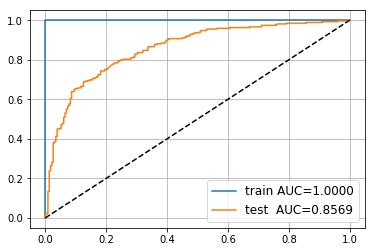

In [57]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [45]:
import warnings
warnings.simplefilter('ignore')

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:48<00:00,  6.37s/it]


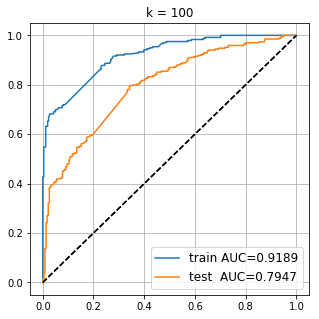

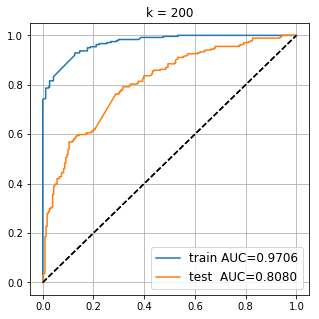

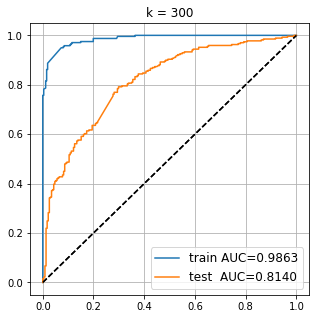

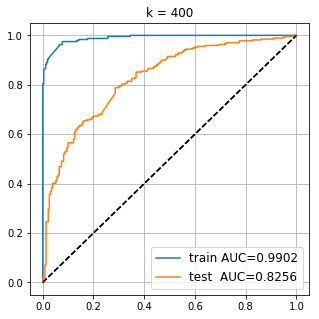

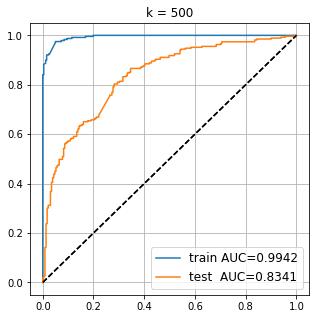

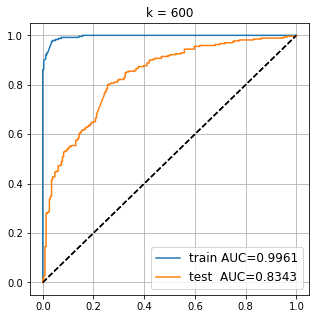

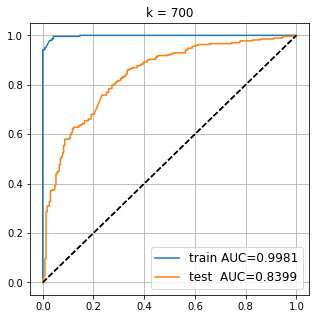

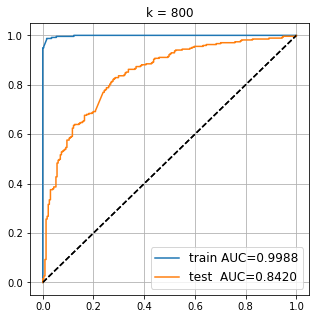

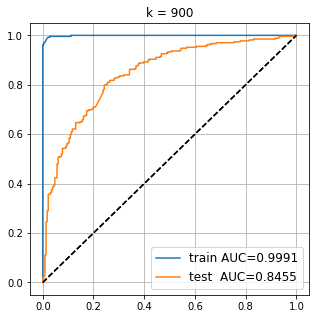

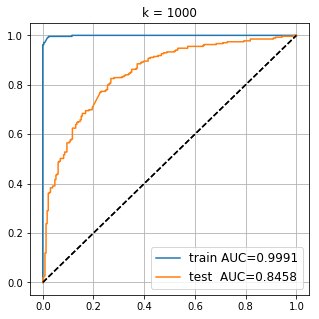

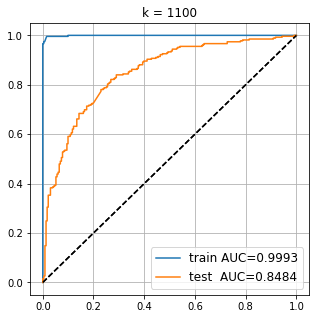

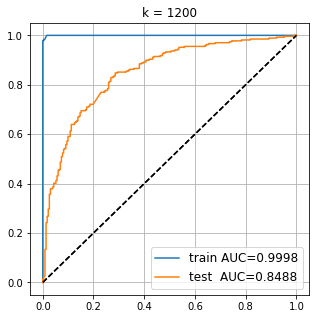

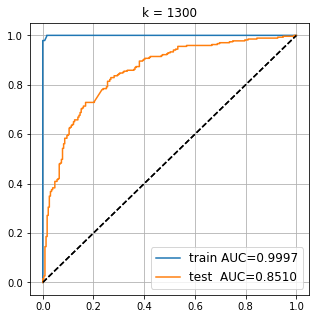

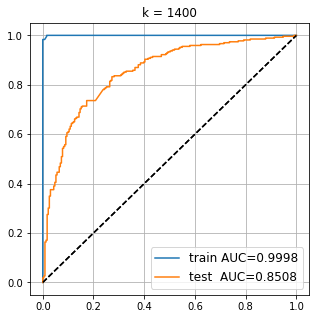

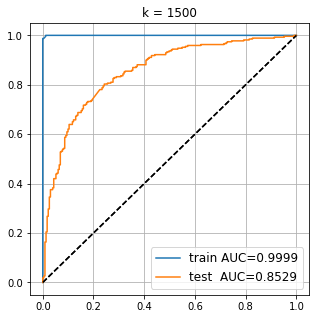

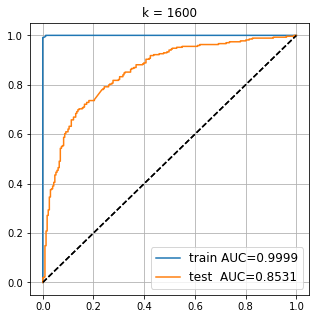

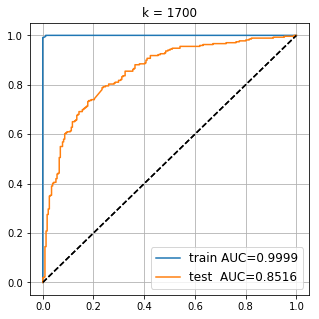

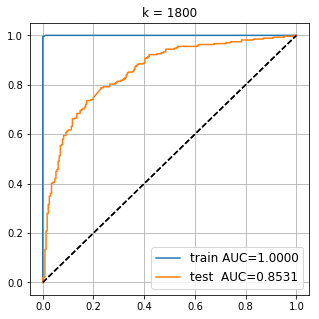

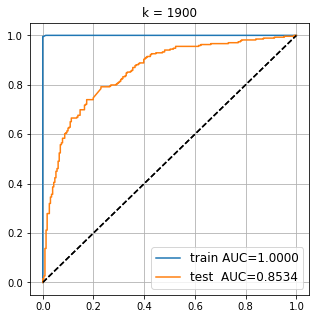

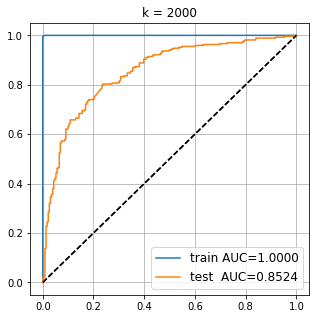

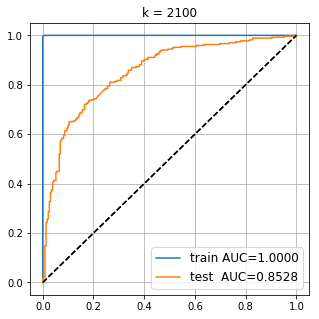

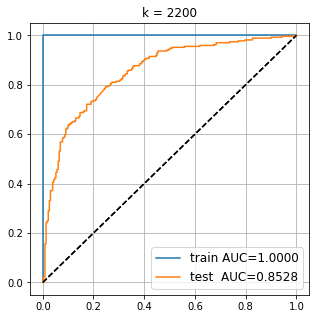

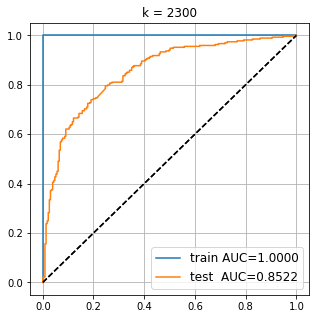

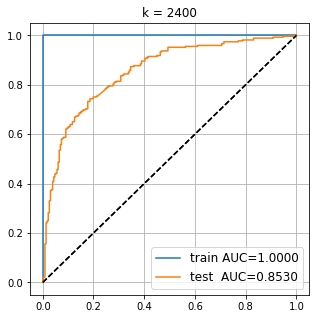

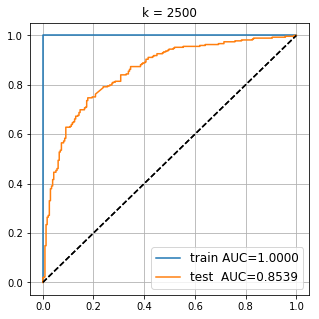

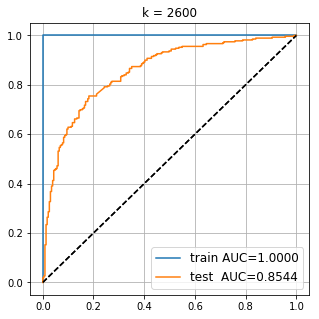

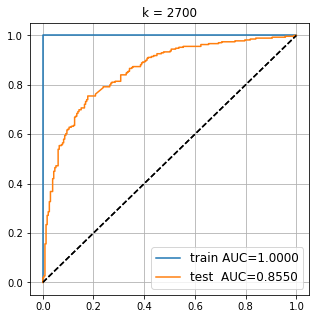

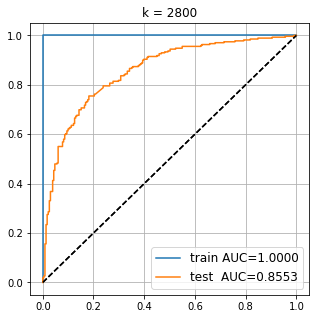

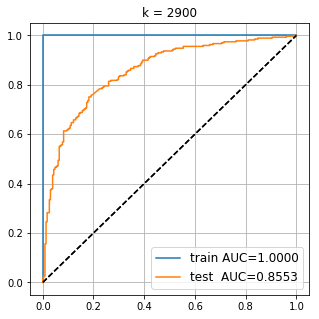

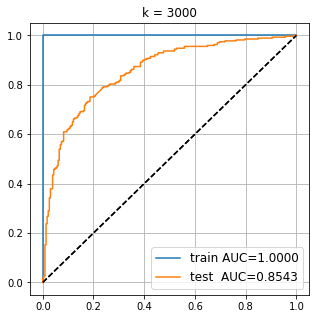

In [73]:
# проделаем все шаги, что и выше, только просто будем менять k
for i in tqdm.tqdm(range(30)):
    k = min(100*(i+1), len(set(' '.join(texts_train).split())))
    
    def text_to_bow_2(text):
        arra = [0]*k
        for word in (text).split():
            for j in range(k):
                if (word == bow_vocabulary[j]):
                    arra[j]+=1
        return np.array(arra, 'float32')
      
    X_train_bow = np.stack(list(map(text_to_bow_2, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow_2, texts_test)))
    
    
    from sklearn.metrics import roc_auc_score, roc_curve
    bow_model = LogisticRegression().fit(X_train_bow, y_train)
    plt.subplots(figsize=(5,5))
    for name, X, y, model in [
        ('train', X_train_bow, y_train, bow_model),
        ('test ', X_test_bow, y_test, bow_model)
    ]:
        proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.title('k = %d' % k)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))
        plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

#### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

(записываем в словарь, после в матрицу)

Считаем TF

In [84]:
# просто сортированный словарь по убыванию частоты встречания
new_vocabulary = []
frequency = []
from collections import Counter
counts = Counter(list_of_all_words)
for word, freq in counts.most_common(10000):
    new_vocabulary.append(word)
    frequency.append(freq)

In [80]:
def making_TF(text):
    TF_dict = {}
    for word in text:
        if word in TF_dict:
            TF_dict[word] += 1
        else:
            TF_dict[word] = 1     
    for word in TF_dict:
        TF_dict[word] = TF_dict[word] / len(text)
    return TF_dict

TF_dict_train=[]
for i in range(len(texts_train)):
    TF_dict_train.append(making_TF(texts_train[i].split()))
    
TF_dict_test=[]
for i in range(len(texts_test)):
    TF_dict_test.append(making_TF(texts_test[i].split()))

TF_train = np.zeros((len(texts_train),len(set(' '.join(texts_train).split()))))
for k in range(len(TF_dict_train)):
    for word in TF_dict_train[k]:
        for i in range(len(new_vocabulary)):
            if (word == new_vocabulary[i]):
                TF_train[k][i] = TF_dict_train[k][word]
                
TF_test = np.zeros((len(texts_test),len(set(' '.join(texts_train).split()))))
for k in range(len(TF_dict_test)):
    for word in TF_dict_test[k]:
        for i in range(len(new_vocabulary)):
            if (word == new_vocabulary[i]):
                TF_test[k][i] = TF_dict_test[k][word]

Считаем IDF

In [85]:
def making_IDF(texts):
    import math
    IDF=[]
    for i in range(len(new_vocabulary)):
        IDF.append(math.log(len(texts) / frequency[i]))
    return IDF

IDF_train = making_IDF(texts_train)
IDF_test = making_IDF(texts_test)

Считаем TF - IDF

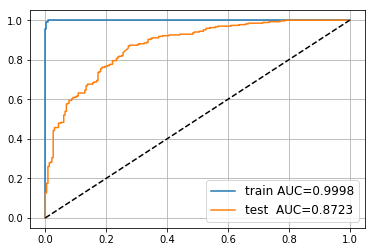

In [86]:
TF_IDF_train = TF_train * IDF_train
TF_IDF_test = TF_test * IDF_test

model = LogisticRegression().fit(TF_IDF_train, y_train)
for name, X, y, model in [
    ('train', TF_IDF_train, y_train, model),
    ('test ', TF_IDF_test, y_test, model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Part 2: gradient boosting (4 points)

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

First you are required to choose one of the main gradient boosting frameworks:
1. LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). One of the most popular frameworks these days that shows both great quality and performance.
2. xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
3. Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features. It's quite new, but if you wish to use it - you are welcome.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 85% accuracy on test dataset.

In [87]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [95]:
cd data/


C:\Users\dexp-pc\Desktop\Phystech\ml-mipt\Homeworks\Lab2_Texts_and_Boosting\data


In [100]:
X_train = np.genfromtxt('train/X_train.txt')
y_train = np.genfromtxt('train/y_train.txt')

X_test = np.genfromtxt('test/X_test.txt')
y_test = np.genfromtxt('test/y_test.txt')

with open('activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [101]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [102]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [104]:
unique_columns = np.genfromtxt('../unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [105]:
pca = PCA(0.99)

In [106]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [107]:
X_train_pca.shape

(7352, 179)

In [108]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

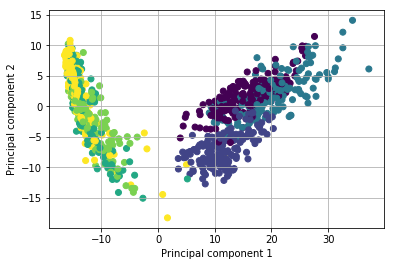

In [109]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

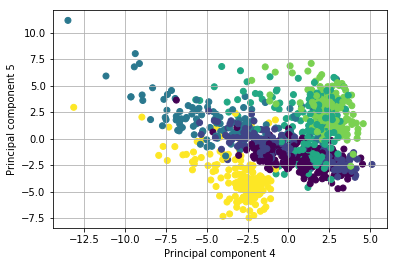

In [110]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

# Комментировать тут нечего, всё по-старинке

## Данная часть вызвала затруднения, ибо параметры на ноутбуке подбирались долго. Я даже запустил на сервере кагла, ждал час, но забил, ибо дедлайн через 10 минут))))
Но код точно верный, без рассчётов :(

In [136]:
import xgboost
from sklearn.metrics import accuracy_score,f1_score
xgboost_mod = xgboost.XGBClassifier()

In [126]:

from sklearn.model_selection import GridSearchCV
grid_mod = GridSearchCV(estimator = xgboost_mod, cv = 5, scoring = 'accuracy',
                     param_grid = {
                         'max_depth' : [3,5,7],
                         'learning_rate' : [0.1],
                         'n_estimators' : [300,500],
                         'gamma' : [0,0.3],
                         'subsample' : [0.5,1]
                     })
grid_mod.fit(X_train_pca, y_train)

print('the best_params : ', grid_mod.best_params_)
print('the best_score  : ', grid_mod.best_score_)

KeyboardInterrupt: 

In [138]:
xgboost_mod_best = xgboost.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=300,gamma=0,subsample=0.5,n_jobs=-1)

In [139]:
%%time
model_xgb_best = xgboost_mod_best.fit(X_train_pca, y_train)
for name, X, y, model1 in ([
    ('train', X_train_pca, y_train, model_xgb_best),
    ('test ', X_test_pca, y_test, model_xgb_best)
]):
    proba = model1.predict(X)
    acc = accuracy_score(y, proba)
    f1 = f1_score(y, proba, average = 'macro')
    print('accuracy_score ',name,' = ',acc)
    print('f1_score ',name,' = ',f1)

accuracy_score  train  =  1.0
f1_score  train  =  1.0
accuracy_score  test   =  0.9277231082456736
f1_score  test   =  0.9249914843161746
Wall time: 2min 30s
